# **GPT2 for text-classification**
<br>

## **References:-**

[1] Hugging Face. (n.d.). Text Classification with Transformers. Retrieved from https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb <br>

[2] Mihaila, G. (n.d.). GPT-2 Fine-Tuning for Text Classification. Retrieved from https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/

## **Dataset**

[IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset).

The description provided on Kaggle:

*This dataset is collected from IMDB. It contains meta-data about items as well as user reviews with information regarding whether a review contains a spoiler or not.*

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
! kaggle datasets download -d rmisra/imdb-spoiler-dataset
! mkdir train
! unzip imdb-spoiler-dataset.zip -d train

In [ ]:
# import raw data from the drive

from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
data = pd.read_json("drive/MyDrive/IMDB_reviews.json", lines =True)

Mounted at /content/drive


In [ ]:
# Split data into training and validation sets

from sklearn.model_selection import train_test_split
data.head(n=4)
texts = data[["review_text"]]
labels = data[["is_spoiler"]]
train_texts, test_texts, train_labels, test_labels= train_test_split(texts, labels, train_size=0.7)

In [ ]:
labels


is_spoiler
0             True
1             True
2             True
3             True
4             True
...            ...
573908       False
573909       False
573910       False
573911       False
573912       False

[573913 rows x 1 columns]

In [ ]:
# Installing transformers library
!pip install -q git+https://github.com/huggingface/transformers.git
# Installing helper function from ml_things
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.8 MB/s eta 0:00:00


In [ ]:
# Description: This code snippet imports necessary libraries and sets up configurations for a GPT-2 sequence classification model.

import io  # Importing the 'io' module for input/output operations
import os  # Importing the 'os' module for operating system related functionalities
import torch  # Importing the PyTorch library for deep learning tasks
from tqdm.notebook import tqdm  # Importing 'tqdm' for progress bar visualization
from torch.utils.data import Dataset, DataLoader  # Importing classes for creating and loading datasets
from ml_things import plot_dict, plot_confusion_matrix, fix_text  # Importing utility functions for visualization and text processing
from sklearn.metrics import classification_report, accuracy_score  # Importing evaluation metrics for classification tasks
from transformers import (set_seed,  # Importing functions and classes from the 'transformers' library for pre-trained models
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

set_seed(123)  # Setting a fixed seed value for reproducibility
epochs = 4  # Number of training epochs
batch_size = 32  # Batch size for training
max_length = 60  # Maximum sequence length
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Checking if GPU is available, else use CPU
model_name_or_path = 'gpt2'  # Pre-trained GPT-2 model name or path
labels_ids = {'False': 0, 'True': 1}  # Mapping labels to numerical IDs
n_labels = len(labels_ids)  # Number of labels in the classification task

## **Custom Dataset Class**
The code snippet defines a custom dataset class `MovieReviewsDataset` for movie reviews, a collator class `Gpt2ClassificationCollator` for GPT-2 classification, and a training function `train`.

The `MovieReviewsDataset` class takes in the data and a tokenizer as input. It initializes the dataset with the given data and calculates the number of examples. The `__len__` method returns the number of examples, and the `__getitem__` method returns a dictionary containing the text and label of a specific item.

The `Gpt2ClassificationCollator` class is responsible for collating sequences for GPT-2 classification. It takes in a tokenizer, a labels encoder, and an optional maximum sequence length. In its `__call__` method, it extracts the texts and labels from the sequences, tokenizes the texts using the tokenizer, and pads/truncates the sequences to the specified maximum length. It returns a dictionary containing the tokenized inputs and the labels.

The `train` function performs the training loop. It takes in a dataloader, an optimizer, a scheduler, and a device. It initializes lists to store the true labels and predicted labels, and sets the model in training mode. It then iterates over the batches in the dataloader, extracts the true labels, moves the batch to the specified device, performs forward and backward passes through the model, calculates the loss, updates the model parameters, and records the true and predicted labels.

In [ ]:
# Description: This code snippet defines a custom dataset class for movie reviews, a collator class for GPT-2 classification, and a training function.

class MovieReviewsDataset(Dataset):
    def __init__(self, data, use_tokenizer):
        self.data = data  # Store the input data
        self.n_examples = len(self.data)  # Calculate the number of examples in the dataset

    def __len__(self):
        return self.n_examples  # Return the number of examples

    def __getitem__(self, item):
        line = self.data.iloc[item]  # Retrieve the item at the specified index
        return {'text': line['review_text'], 'label': line['is_spoiler']}  # Return a dictionary with the text and label

class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer  # Store the tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len  # Determine the maximum sequence length
        self.labels_encoder = labels_encoder  # Store the labels encoder

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]  # Extract the texts from the sequences
        labels = [sequence['label'] for sequence in sequences]  # Extract the labels from the sequences
        print(labels)  # Print the labels (for debugging purposes)
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True, max_length=self.max_sequence_len)  # Tokenize the texts
        inputs.update({'labels': torch.tensor(labels)})  # Add the labels to the inputs dictionary
        return inputs  # Return the tokenized inputs

def train(dataloader, optimizer_, scheduler_, device_):
    global model
    predictions_labels = []  # List to store the predicted labels
    true_labels = []  # List to store the true labels
    total_loss = 0  # Variable to track the total loss
    model.train()  # Set the model to training mode

    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()  # Append the true labels to the list
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}  # Move the batch to the specified device and convert the data type
        model.zero_grad()  # Reset the gradients
        outputs = model(**batch)  # Forward pass through the model
        loss, logits = outputs[:2]  # Extract the loss and logits from the outputs
        total_loss += loss.item()  # Update the total loss
        loss.backward()  # Backward pass and gradient computation
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip the gradients to avoid exploding gradients
        optimizer.step()  # Update the model parameters
        scheduler.step()  # Adjust the learning rate using the scheduler
        logits = logits.detach().cpu().numpy()  # Detach the logits from the computational graph and move to CPU
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()  # Append the predicted labels to the list

    avg_epoch_loss = total_loss / len(dataloader)  # Calculate the average epoch loss
    return true_labels, predictions_labels, avg_epoch_loss  # Return the true labels, predicted labels, and


def validation(dataloader, device_):
    global model
    predictions_labels = []  # List to store the predicted labels
    true_labels = []  # List to store the true labels
    total_loss = 0  # Variable to track the total loss
    model.eval()  # Set the model to evaluation mode

    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()  # Append the true labels to the list
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}  # Move the batch to the specified device and convert the data type

        with torch.no_grad():
            outputs = model(**batch)  # Forward pass through the model without gradient computation
            loss, logits = outputs[:2]  # Extract the loss and logits from the outputs
            logits = logits.detach().cpu().numpy()  # Detach the logits from the computational graph and move to CPU
            total_loss += loss.item()  # Update the total loss
            predict_content = logits.argmax(axis=-1).flatten().tolist()  # Obtain the predicted labels
            predictions_labels += predict_content  # Append the predicted labels to the list

    avg_epoch_loss = total_loss / len(dataloader)  # Calculate the average epoch loss
    return true_labels, predictions_labels, avg_epoch_loss  # Return the true labels, predicted labels, and average epoch loss


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **GPT-2 Model and Tokenizer**

In [ ]:
# set up gpt-2 model and tokenizer

print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left" #add padding
tokenizer.pad_token = tokenizer.eos_token #set eos token


print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id.  # fix the model's padding token id

model.to(device)
print('Model loaded to `%s`'%device).   # load model to cuda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...


Loading tokenizer...


Loading model...


Some weights of the model checkpoint at gpt2 were not used when initializing GPT2ForSequenceClassification: ['h.10.attn.bias', 'h.1.attn.bias', 'h.4.attn.bias', 'h.2.attn.bias', 'h.8.attn.bias', 'h.6.attn.bias', 'h.11.attn.bias', 'h.9.attn.bias', 'h.3.attn.bias', 'h.7.attn.bias', 'h.5.attn.bias', 'h.0.attn.bias']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-

Model loaded to `cuda`


In [ ]:
# Create an instance of the Gpt2ClassificationCollator class for collating sequences.
gpt2_classification_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)

print('Dealing with Train...')

# Make a copy of train_labels for testing.
test = train_labels

# Convert the "is_spoiler" column in train_labels to integer type.
train_labels["is_spoiler"] = train_labels["is_spoiler"].astype(int)

# Concatenate 10% of train_texts and train_labels along the columns.
train_dataset = train_dataset.sample(frac = 0.1)
train_dataset = pd.concat([train_texts, train_labels], axis=1)

# Create an instance of the MovieReviewsDataset class for the training dataset.
train_dataset = MovieReviewsDataset(train_dataset, use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!' % len(train_dataset))

# Create a DataLoader for the training dataset.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classification_collator)
print('Created `train_dataloader` with %d batches!' % len(train_dataloader))
print('')

print('Dealing with Validation...')

# Convert the "is_spoiler" column in test_labels to integer type.
test_labels["is_spoiler"] = test_labels["is_spoiler"].astype(int)

# Concatenate 10% of test_texts and test_labels along the columns.
valid_dataset = valid_dataset.sample(frac = 0.1)
valid_dataset = pd.concat([test_texts, test_labels], axis=1)

# Create an instance of the MovieReviewsDataset class for the validation dataset.
valid_dataset = MovieReviewsDataset(valid_dataset, use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!' % len(valid_dataset))

# Create a DataLoader for the validation dataset.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classification_collator)
print('Created `eval_dataloader` with %d batches!' % len(valid_dataloader))


Dealing with Train...
Created `train_dataset` with 40174 examples!
Created `train_dataloader` with 1256 batches!

Dealing with Validation...
Created `valid_dataset` with 17217 examples!
Created `eval_dataloader` with 539 batches!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
td =  pd.concat([train_texts, train_labels], axis=1)

td = td.sample(frac = 0.10)
td

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


review_text  is_spoiler
201975  Billed as a funny sort of superhero movie. Unf...       False
329084  How can Jack Black top this?  It was a role MA...       False
240987  This Cold War history describes (with Spielber...        True
324746  This movie was very good. I have always enjoye...        True
211623  I can't say that I'm really a fan of the sourc...        True
...                                                   ...         ...
80916   This is a great WWII movie and a must see. Unt...       False
253628  I love this movie. It is so much inspiring as ...       False
410668  Being a lifetime fan of the Superman character...        True
550547  This is science fiction at its' best and Alex ...       False
552166  Urban Legend was a very well done film...After...       False

[40174 rows x 2 columns]

In [ ]:
# Printing and checking the data
it = iter(train_dataloader)
first = next(it)
test = train_labels
test["is_spoiler"] = test["is_spoiler"].astype(int)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be 

## **Training the model**

Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1256 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

Validation on batches...


  0%|          | 0/539 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

  train_loss: 0.55728 - val_loss: 0.53163 - train_acc: 0.74053 - valid_acc: 0.75303


Training on batches...


<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning:

  0%|          | 0/1256 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

Validation on batches...


  0%|          | 0/539 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

  train_loss: 0.52797 - val_loss: 0.52859 - train_acc: 0.75198 - valid_acc: 0.75466


Training on batches...


<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning:

  0%|          | 0/1256 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

Validation on batches...


  0%|          | 0/539 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

  train_loss: 0.50778 - val_loss: 0.53550 - train_acc: 0.76166 - valid_acc: 0.74438


Training on batches...


<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning:

  0%|          | 0/1256 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

Validation on batches...


  0%|          | 0/539 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

  train_loss: 0.48649 - val_loss: 0.54100 - train_acc: 0.77371 - valid_acc: 0.74816



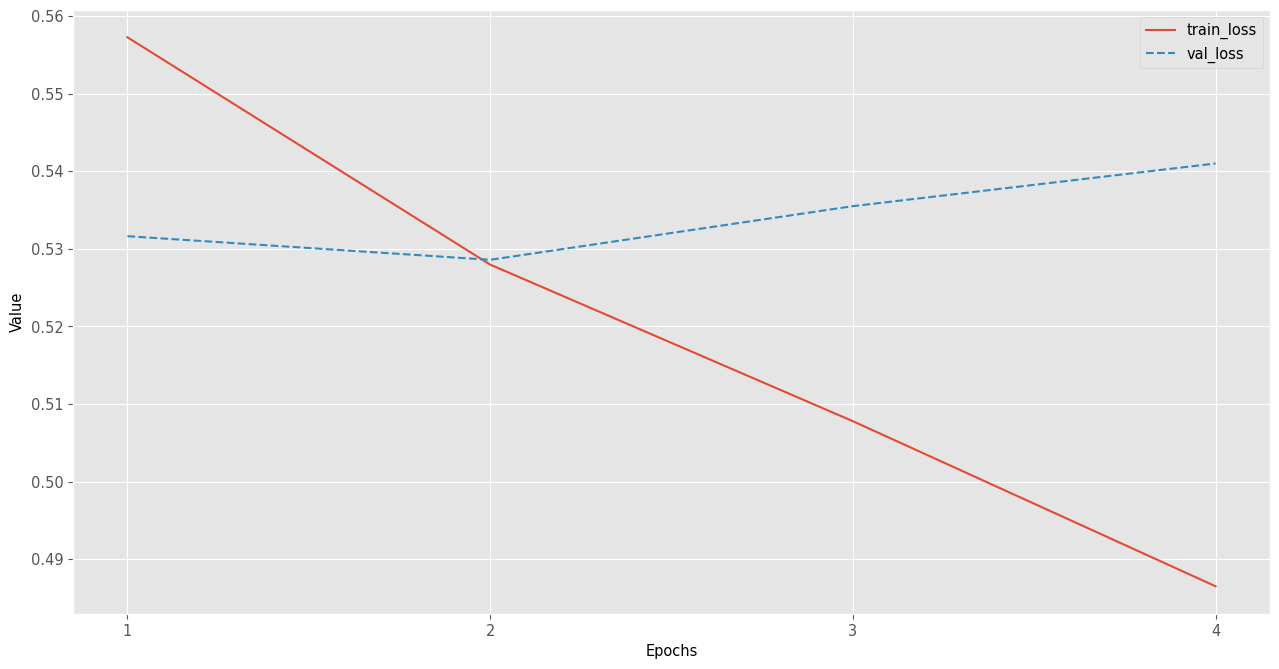

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


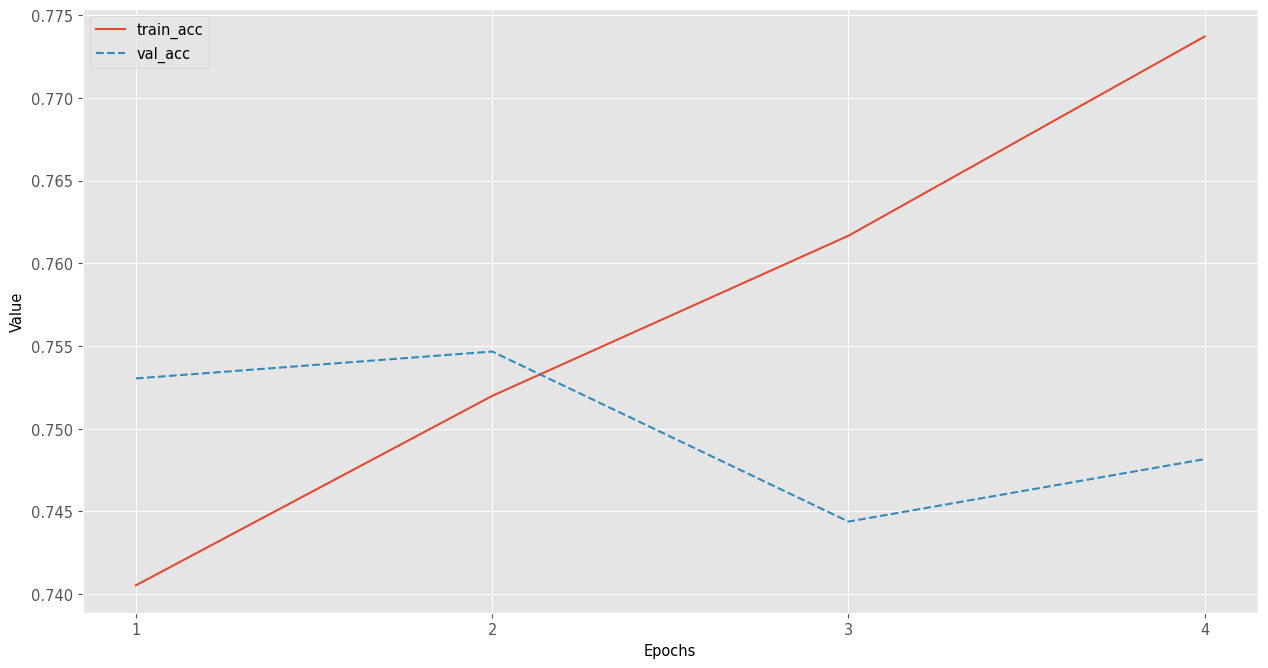

In [ ]:
# Initialize the AdamW optimizer with model parameters, learning rate, and epsilon.
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8
                  )

# Calculate the total number of steps for the scheduler.
total_steps = len(train_dataloader) * epochs

# Create a scheduler with linear warmup.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Initialize dictionaries to store training and validation loss.
all_loss = {'train_loss': [], 'val_loss': []}

# Initialize dictionaries to store training and validation accuracy.
all_acc = {'train_acc': [], 'val_acc': []}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Train the model on training batches.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)

  # Calculate the training accuracy.
  train_acc = accuracy_score(train_labels, train_predict)

  print('Validation on batches...')
  # Evaluate the model on validation batches.
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)

  # Calculate the validation accuracy.
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print the training and validation loss and accuracy for the current epoch.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f" % (train_loss, val_loss, train_acc, val_acc))
  print()

  # Append the training and validation loss to the dictionaries.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)

  # Append the training and validation accuracy to the dictionaries.
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot the training and validation loss.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot the training and validation accuracy.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


## **Metrics**

Please scroll down to the bottom of the warnings to see the metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/539 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipython-input-9-10a6a677b2d4>:132: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  inputs.update({'labels':torch.tensor(labels)})
<ipy

              precision    recall  f1-score   support

       False       0.77      0.94      0.85     12725
        True       0.55      0.21      0.30      4492

    accuracy                           0.75     17217
   macro avg       0.66      0.57      0.57     17217
weighted avg       0.71      0.75      0.70     17217

Normalized confusion matrix


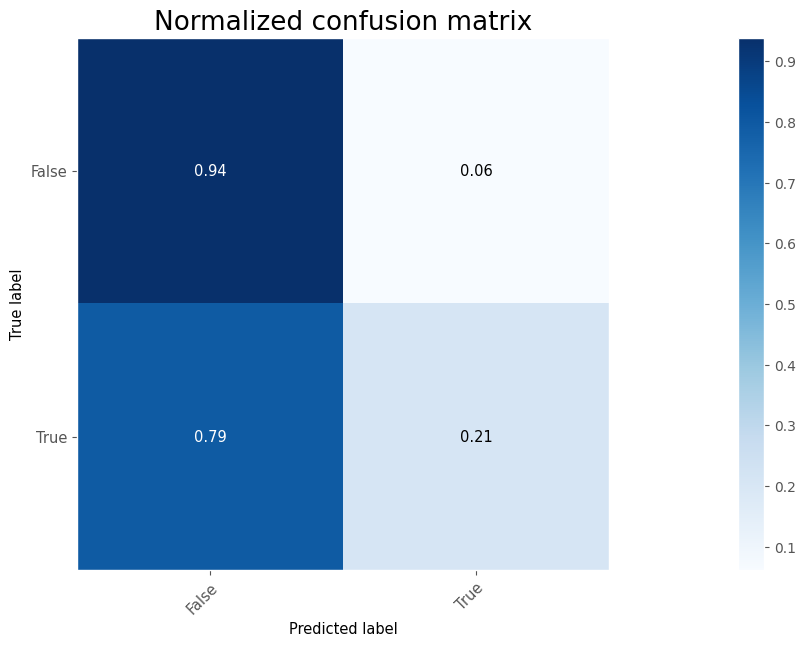

In [ ]:
# Perform validation on the validation dataloader.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Generate the classification report using true labels and predicted labels.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))

# Print the evaluation report.
print(evaluation_report)

# Plot the confusion matrix using true labels and predicted labels.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1)


## **Metrics Images**

Screenshots of the above metrics for convinience


Screen Shot 2023-05-16 at 1.29.36 PM.png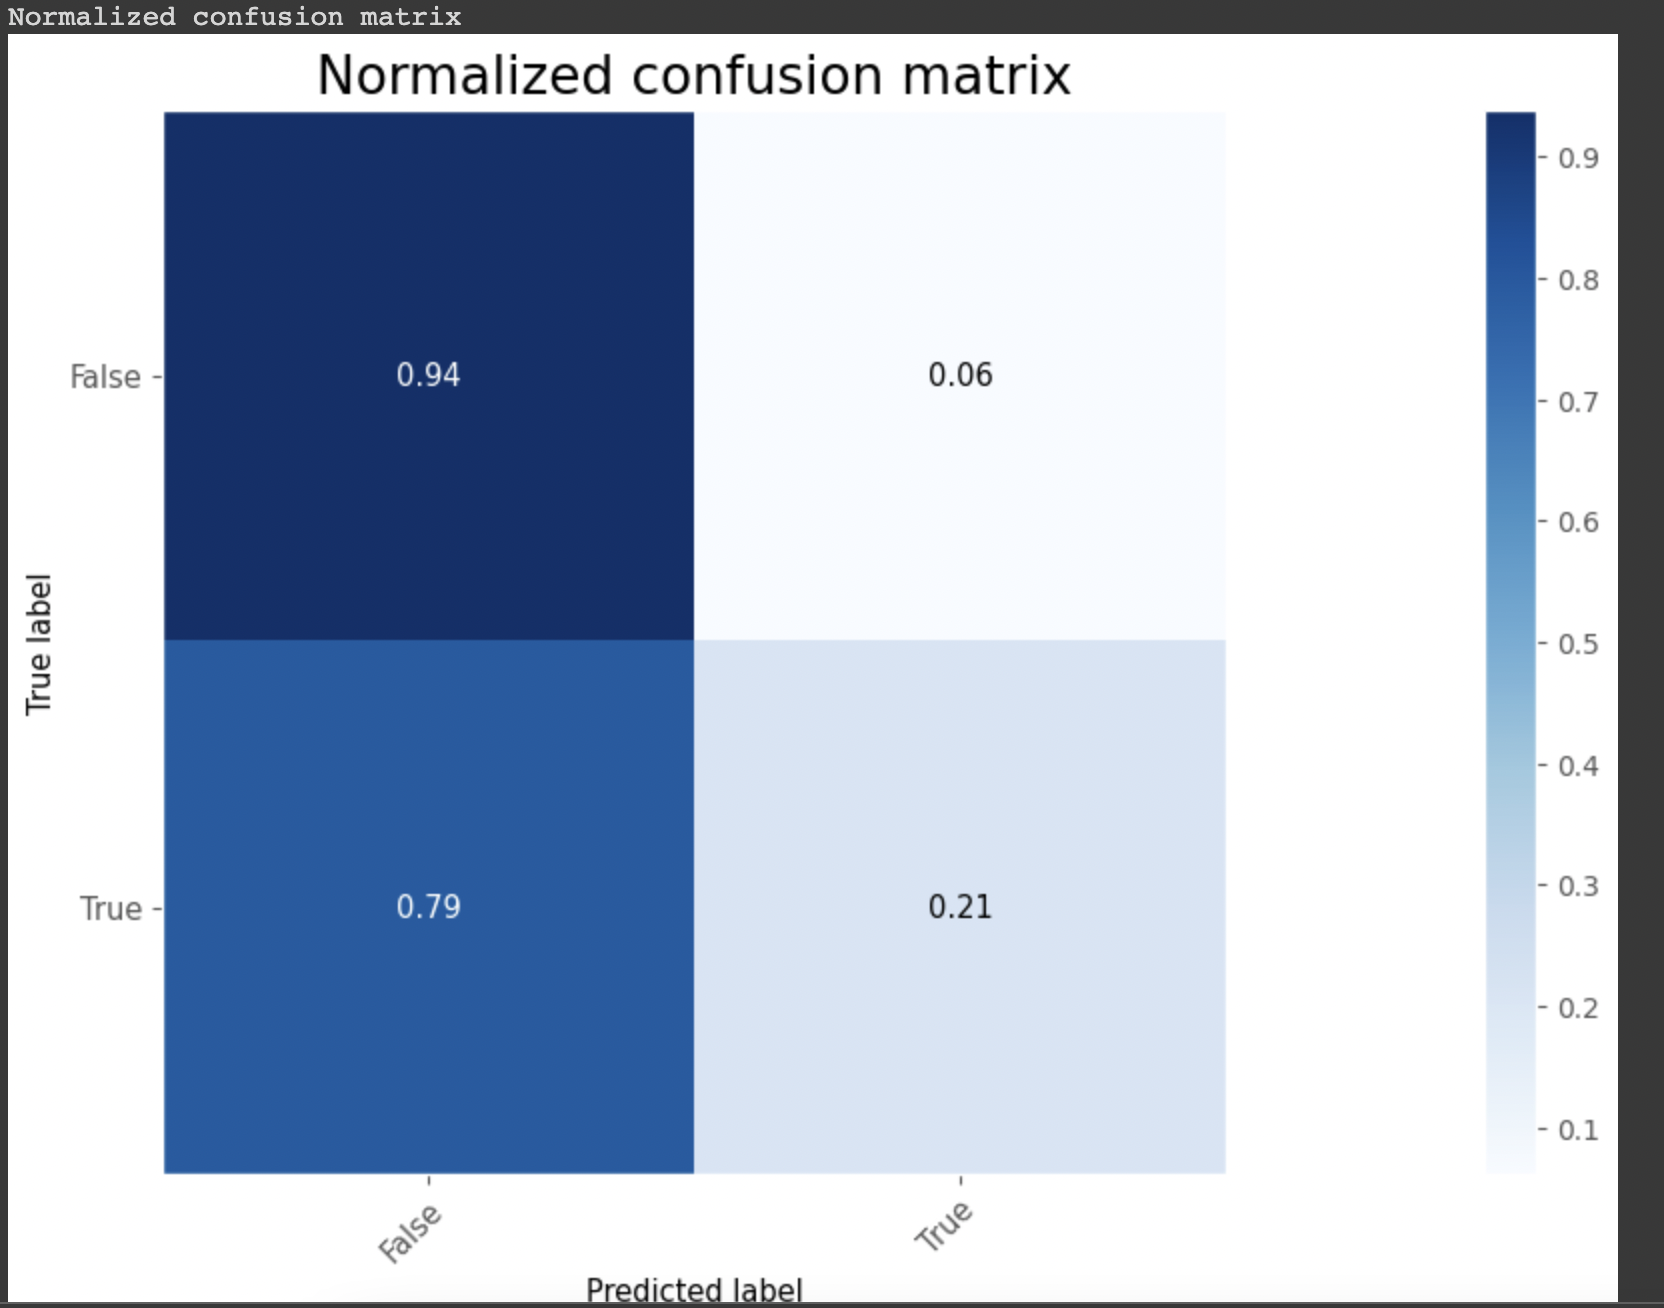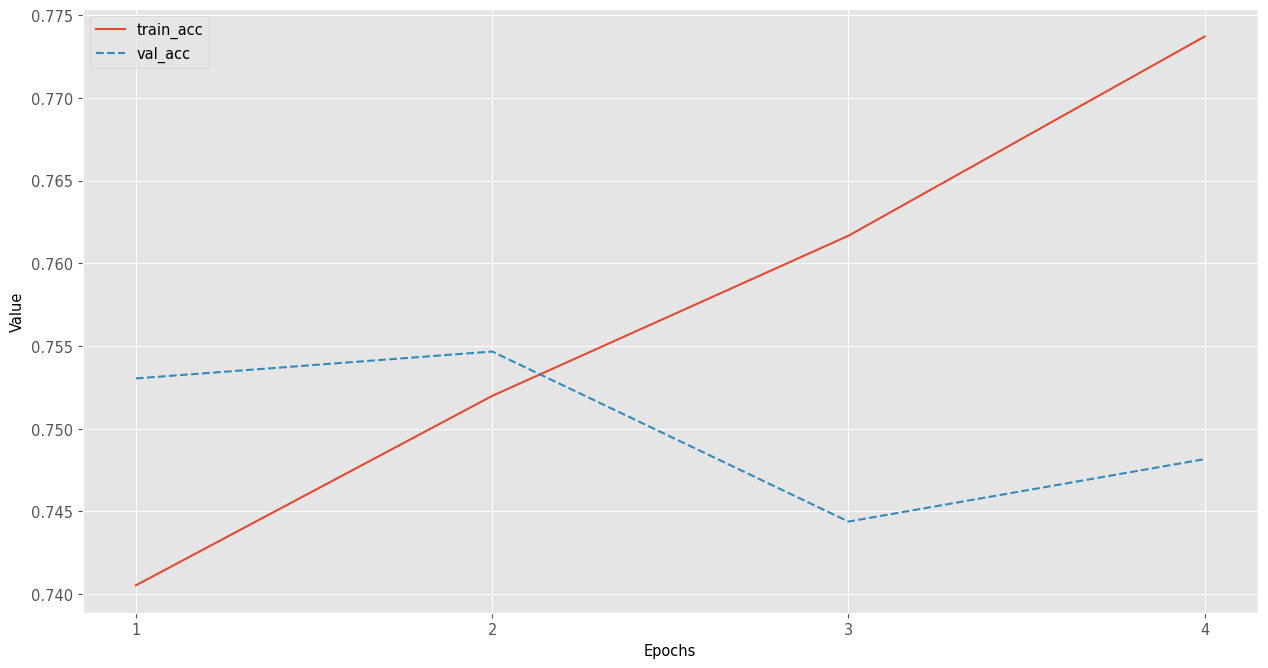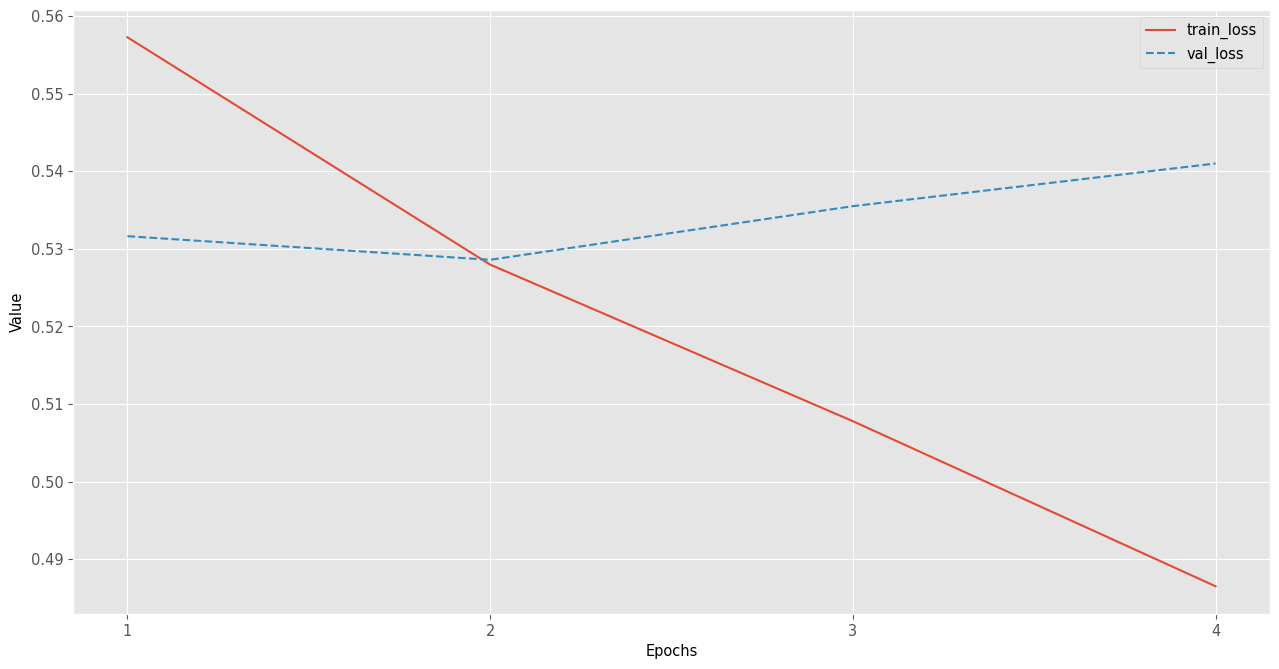